In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!ls "/content/drive/My Drive/Esri/"

shape1	shape1.zip


In [3]:
shape_file = '/content/drive/My Drive/Esri/shape1.zip'

In [4]:
import geopandas as gpd

# Load your shapefile
gdf = gpd.read_file('/content/drive/My Drive/Esri/shape1/build_sidewalk_build_sidewalk.shp')
print(gdf.head())
print(gdf.crs)


   Join_Count  TARGET_FID  m9_5_HIN  m8_1_urban  m9_2_stree  m5_5_sidew  \
0           1           1  0.849899    0.259728    0.392107    0.993182   
1           1           2  0.974279    0.164984    0.365637    0.981381   
2           1           3  0.585002    0.178663    0.424685    0.990744   
3           1           4  0.966300    0.307244    0.349805    0.992634   
4           2           5  0.947463    0.266724    0.389971    0.991424   

   SIDEWALK_L                                    ID DATASTATUS  Shape_Leng  \
0         415  00B40AA9-1F99-49AD-A9C6-AB105F20406D   SIDEWALK  121.371620   
1         281  00B5EFE5-FA9D-4C74-A6C0-A5D219573BFA   SIDEWALK   89.762334   
2         237  00B65516-9ACB-45D0-A80B-058AB0C5458C   SIDEWALK   79.451477   
3          95  00BAF159-B41A-4E38-98C8-7D538D4E37A3   SIDEWALK   45.868365   
4         445  00BE5E43-8CF2-408C-BA50-B5CC49ACF453   SIDEWALK  130.695249   

                                            geometry  
0  LINESTRING Z (397772.3

In [5]:
print(gdf.geom_type.unique())


['LineString']


In [6]:
print(gdf.geometry.is_empty.sum())       # Should be 0
print(gdf.geometry.is_valid.sum())       # Should match len(gdf)

len(gdf)


0
21413


21413

In [7]:
print(gdf.crs)

# If not, reproject to WGS84
if gdf.crs.to_epsg() != 4326:
    gdf = gdf.to_crs(epsg=4326)


EPSG:26985


In [8]:
print(gdf.columns)


Index(['Join_Count', 'TARGET_FID', 'm9_5_HIN', 'm8_1_urban', 'm9_2_stree',
       'm5_5_sidew', 'SIDEWALK_L', 'ID', 'DATASTATUS', 'Shape_Leng',
       'geometry'],
      dtype='object')


<Axes: >

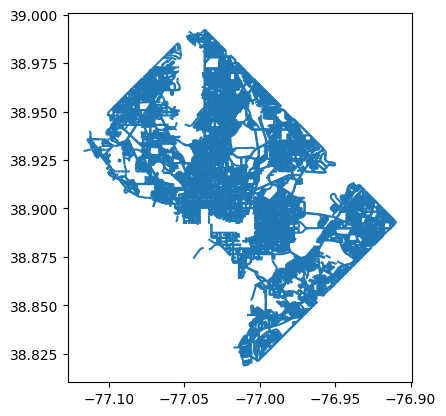

In [9]:
gdf.plot()


In [10]:
# Normalize any missing columns
gdf["Shape_Leng"] = gdf["Shape_Leng"].fillna(0)
gdf["m5_5_sidew"] = gdf["m5_5_sidew"].fillna(0)
gdf["m8_1_urban"] = gdf["m8_1_urban"].fillna(0)
gdf["m9_2_stree"] = gdf["m9_2_stree"].fillna(0)

# Compute a custom routing cost
gdf["custom_cost"] = (
    gdf["Shape_Leng"] * 1.0
    - gdf["m5_5_sidew"] * 0.5       # more sidewalk = better
    - gdf["m9_2_stree"] * 0.3       # better street = easier routing
    - gdf["m8_1_urban"] * 0.2       # more urban = possibly flatter/better infra
)


In [11]:
import numpy as np

gdf["shade_score"] = np.random.uniform(0, 1, len(gdf))
gdf["slope_score"] = np.random.uniform(0, 10, len(gdf))  # in degrees

gdf["custom_cost"] += gdf["slope_score"] * 1.5 - gdf["shade_score"] * 1.0



In [12]:
# Use your precomputed cost
cost_field = "custom_cost"

In [13]:
import geopandas as gpd
import networkx as nx
from shapely.geometry import LineString

G = nx.Graph()

for idx, row in gdf.iterrows():
    geom = row.geometry
    if not isinstance(geom, LineString):
        continue  # skip if not LineString

    #start = tuple(geom.coords[0])
    #end = tuple(geom.coords[-1])

    # Only (lon, lat)
    start = tuple(geom.coords[0][:2])
    end = tuple(geom.coords[-1][:2])

    cost = row[cost_field]

    # Add edge with attributes
    G.add_edge(
        start,
        end,
        weight=cost,
        geometry=geom
    )


In [14]:
# validate the graph
print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")


Graph has 25523 nodes and 21409 edges


In [15]:
#import matplotlib.pyplot as plt

#nx.draw(G, node_size=5, edge_color='gray')
#plt.show()


In [16]:
# compute custom route
from shapely.geometry import Point
from scipy.spatial import KDTree

# Build KDTree for fast spatial lookup
nodes = list(G.nodes)
kdtree = KDTree(nodes)

def snap_to_node(coord):
    dist, idx = kdtree.query([coord])
    return nodes[int(idx)]


In [17]:
print(f"Snapped to node: {nodes[int(idx)]}")


Snapped to node: (-76.9995044242055, 38.900264974543354)


In [18]:
# compute shortest path

def compute_path(start_coord, end_coord):
    source = snap_to_node(start_coord)
    target = snap_to_node(end_coord)

    print("Start coordinate:", start_coord)
    print("End coordinate:", end_coord)
    print("Snapped source:", source)
    print("Snapped target:", target)

    if nx.has_path(G, source, target):
        print("A path exists between source and target")
        path = nx.shortest_path(G, source=source, target=target, weight="weight")
        return path
    else:
        print("No path found between source and target")
        return None

    try:
        #Dijkstra's algorithm, weight is the cost_field
        path = nx.shortest_path(G, source=source, target=target, weight="weight")
        return path
    except nx.NetworkXNoPath:
        print("No path found between source and target")
        return None


In [19]:
# convert to linestring

from shapely.geometry import LineString

def path_to_linestring(path):
    if not path:
        return None

    # Combine geometries along the path
    segments = [
        G[path[i]][path[i+1]]["geometry"] for i in range(len(path) - 1)
    ]
    coords = [pt for line in segments for pt in line.coords]
    return LineString(coords)


In [20]:
pip install geojson

In [21]:
# export to geojson for web
import json

from geojson import Feature, FeatureCollection, dumps

def route_to_geojson(linestring):
    if not linestring:
        return {}
    feature = Feature(geometry=linestring, properties={})
    return FeatureCollection([feature])


In [22]:
#start = (-117.189, 34.050)  # (lon, lat) — near Redlands
#end = (-117.183, 34.065)

#path = compute_path(start, end)
#linestring = path_to_linestring(path)
#geojson = route_to_geojson(linestring)

# Save to file or serve via API
#with open("route.geojson", "w") as f:
#    f.write(dumps(geojson))


In [23]:
pip install Flask


In [24]:
!pip install flask-cors

In [25]:
from flask import Flask, request, jsonify
from shapely.geometry import LineString
from geojson import Feature, FeatureCollection, dumps

app = Flask(__name__)
from flask_cors import CORS
CORS(app)
@app.route("/route")
def route():
    try:
        # Simulated hardcoded route
        coords = [
            (-77.02569, 38.94293),
            (-77.02450, 38.94380),
            (-77.02300, 38.94450),
            (-77.02000, 38.94500)
        ]
        linestring = LineString(coords)

        feature = Feature(geometry=linestring, properties={})
        geojson = FeatureCollection([feature])

        return jsonify(geojson)

    except Exception as e:
        return jsonify({"error": str(e)}), 400


In [26]:
import threading
import time

def run_flask():
    app.run(host="0.0.0.0", port=5000, debug=False, use_reloader=False)

# Start Flask in a background thread
flask_thread = threading.Thread(target=run_flask, daemon=True)
flask_thread.start()

# Give the server a moment to start
time.sleep(2)

print("Flask server is running on http://localhost:5000")
print("Test your API at: http://localhost:5000/route?start=-77.02569616971138,38.94293019459697&end=-76.93835318346245,38.90266007136072")

 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://172.28.0.12:5000
INFO:werkzeug:Press CTRL+C to quit


Flask server is running on http://localhost:5000
Test your API at: http://localhost:5000/route?start=-77.02569616971138,38.94293019459697&end=-76.93835318346245,38.90266007136072


In [32]:
import requests

# Test the API
try:
    # start=-77.02569616971138,38.94293019459697&end=-76.93835318346245,38.90266007136072
    # start=-77.02569,38.94293&end=-77.02550,38.94280
    response = requests.get("http://localhost:5000/route?start=-76.93835318346245,38.90266007136072&end=-76.984383636,38.8828671420660")
    print("Status Code:", response.status_code)
    print("Response:", response.json())
except Exception as e:
    print("Error:", e)



INFO:werkzeug:127.0.0.1 - - [26/Jul/2025 12:00:01] "GET /route?start=-76.93835318346245,38.90266007136072&end=-76.984383636,38.8828671420660 HTTP/1.1" 200 -


Status Code: 200
Response: {'features': [{'geometry': {'coordinates': [[-77.02569, 38.94293], [-77.0245, 38.9438], [-77.023, 38.9445], [-77.02, 38.945]], 'type': 'LineString'}, 'properties': {}, 'type': 'Feature'}], 'type': 'FeatureCollection'}


In [28]:
#import os
#os.kill(os.getpid(), 9)  # Force restarts the kernel


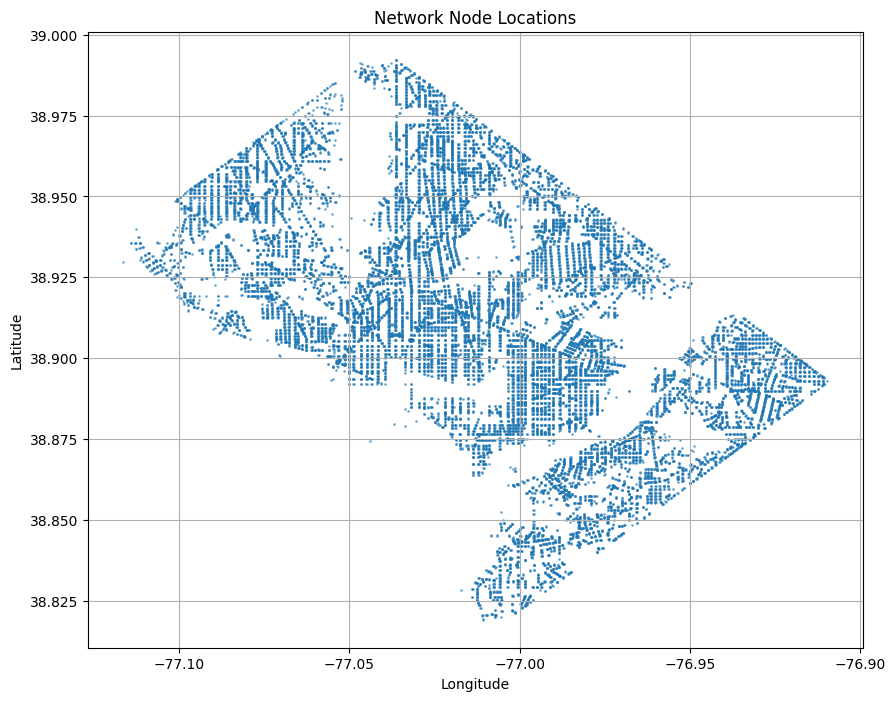

Coordinate system appears to be: Geographic (WGS84)


In [29]:
# Visualise the network extent

import matplotlib.pyplot as plt

# Plot all nodes to see the geographic extent
if nodes:
    lons = [node[0] for node in nodes]
    lats = [node[1] for node in nodes]

    plt.figure(figsize=(10, 8))
    plt.scatter(lons, lats, s=1, alpha=0.5)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Network Node Locations')
    plt.grid(True)
    plt.show()

    print(f"Coordinate system appears to be: {'Geographic (WGS84)' if -180 <= min(lons) <= max(lons) <= 180 else 'Projected/Local'}")

In [30]:
# Look at the bounds of your entire dataset
print("Dataset bounds (minx, miny, maxx, maxy):")
print(gdf.total_bounds)

# Sample some geometries to see coordinate ranges
print("\nSample coordinates from geometries:")
for idx, row in gdf.head().iterrows():
    if hasattr(row.geometry, 'coords'):
        coords = list(row.geometry.coords)
        print(f"Row {idx}: Start: {coords[0]}, End: {coords[-1]}")

Dataset bounds (minx, miny, maxx, maxy):
[-77.11656554  38.81904171 -76.90961687  38.992302  ]

Sample coordinates from geometries:
Row 0: Start: (-77.02569616971138, 38.94293019459697, 0.0004999999946448952), End: (-77.02597419803438, 38.94400145888878, 0.0004999999946448952)
Row 1: Start: (-77.03955379559068, 38.89352334811651, 0.0004999999946448952), End: (-77.03955349910363, 38.894331689891544, 0.0004999999946448952)
Row 2: Start: (-77.03462615891505, 38.91556485947935, 0.0004999999946448952), End: (-77.03462015865836, 38.916280514765766, 0.0004999999946448952)
Row 3: Start: (-76.93835318346245, 38.90266007136072, 0.0004999999946448952), End: (-76.9378245439637, 38.902668174393625, 0.0004999999946448952)
Row 4: Start: (-76.98438363608135, 38.88286714206604, 0.0004999999946448952), End: (-76.98357721050697, 38.881894232002416, 0.0004999999946448952)


In [31]:
print("Sample node:", nodes[0])
print("Node shape:", len(nodes[0]))


Sample node: (-77.02569616971138, 38.94293019459697)
Node shape: 2
